<font size="3"> I show how to create surnames and first names datasets from the data of the Facebook leak of 2021. It covers about 100 countries. Not putting the link here but it can be found easily in torrent format.

# Extracting the data

The data takes the form of multiple compressed files, one for each country. The compression format is either zip, rar or 7zip. The files are in csv format with either a comma or colon separator. Sometimes the below function didn't work because the file was too big or invalid or the format was different. In this case I took a custom approach not detailed here. 

In [1]:
from glob import glob
import io
import re
import zipfile
import rarfile
import os 
from string import punctuation, ascii_letters
import numpy as np
import pandas as pd

def get_sep(file): #The separator is sometimes a comma and sometimes a colon. This function finds the kind of separator of the file.
    head_a = str(file[:5000])
    comma_count = head_a.count(",")
    colon_count = head_a.count(":")
    if comma_count > colon_count :
        sep = ","
    else:
        sep=":"
    return sep


def df_from_archive(archive):
    df_list = []
    files = archive.namelist()  #the data is usually split into multiple files inside the archive
    
    for file in files : 
        print(file)
        
        with archive.open(file) as myfile:
            a = myfile.read()
            sep = get_sep(a)

            try:
                chunks_list = [] #loading files in chunks to avoid crashing               
                for chunk in pd.read_table(io.StringIO(a.decode("utf-8")),sep=sep,header=None,usecols=[2,3,4], quoting=3,engine="c",dtype=pd.StringDtype(),chunksize=1000000):
                    chunks_list.append(chunk)
                df = pd.concat(chunks_list)
                
            except:
                chunks_list = []
                print("failure,switching to python engine")  #sometimes the c engine will crash, in that case the python engine can sometimes do the trick
                for chunk in pd.read_table(io.StringIO(a.decode("utf-8")),sep=sep,header=None,usecols=[2,3,4], quoting=3,engine="python",dtype=pd.StringDtype(),chunksize=1000000):
                    chunks_list.append(chunk)
                df = pd.concat(chunks_list)

            df.columns = ["first_name","surname","gender"]
            df_list.append(df)
            
    df = pd.concat(df_list)
    return df


def get_df(compressed_file):
    try:
        if ".zip" in compressed_file:
            with zipfile.ZipFile(compressed_file, 'r') as archive:
                df = df_from_archive(archive)

        elif ".rar" in compressed_file:
            with rarfile.RarFile(compressed_file, 'r') as archive: 
                df = df_from_archive(archive)
    except:
        print("File error : ", compressed_file)  
        
    return df

I create two dataframes for each country, one for first names, one for surnames.

In [ ]:
files = glob("facebook/*.rar") + glob("facebook/*.zip")
print(len(files), " countries")

for directory in ["surnames", "first_names"]:
    if not os.path.exists(directory):
        os.makedirs(directory)

for n,file in enumerate(files) :
    country = file.replace("facebook/",'').replace(".zip","").replace(".rar","").lower()
    print('n°' + str(n+1) +" : " + country)
    
    df = get_df(file)
    
    surnames = df["surname"].value_counts().rename("count")
    print("len surnames : ", len(surnames))
    surnames.to_csv(f'surnames/{country}_surnames.csv')
    
    #also extracting a first name dataset just in case
    first_names = df[["first_name","gender"]].value_counts().rename("count")
    print("len first names : ", len(first_names))
    first_names.to_csv(f'first_names/{country}_first_names.csv')
               
    print(country, " done",end="\n\n")


<font size="3">Here I reproduce the data transformation and machine learning parts of Antoine Mazières and Camille Roth's paper *'Large-scale diversity estimation through surname origin inference'* : https://namograph.antonomase.fr/ .
First doing the same thing on the same data without reusing their code and trying a different model for the sake of fun.</font>

In [1]:
import pandas as pd
import numpy as np
from string import punctuation, ascii_letters
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import pickle
#dictionnary mapping non ascii to ascii characters
caract_mapping = pd.read_html('https://docs.oracle.com/cd/E29584_01/webhelp/mdex_basicDev/src/rbdv_chars_mapping.html')
carac_dict = pd.DataFrame(np.concatenate([caract_mapping[i].iloc[:,[1,2]].values for i in (0,1)])).set_index(0).to_dict('dict')[1]

def name_cleaner(name):
    clean = ""
    for letter in name:
        if (letter.lower() in ascii_letters) or (letter.lower() in """ ''`'-  """):
            clean += letter
        elif letter in punctuation:
            return 'ERROR'
        elif letter in carac_dict.keys():
            clean += carac_dict[letter]
        else:
            return 'ERROR'
            
    return clean.upper()

#reusing exactly the same clusters
clusters = {
    "African": ["Zimbabwe","Rwanda","Zambia","Malawi","Tanzania","Uganda","Kenya","Dem. Rep. Congo","Congo","South Africa","Gambia","Botswana","Mozambique","Mali","Trinidad and Tobago","Gabon","Cameroon","Benin","Côte d'Ivoire","Burkina Faso","Togo","Senegal","Nigeria","Ghana","Ethiopia"],
    "Asian": ["Vietnam","China","Thailand","Cambodia","Taiwan","Korea","Lao PDR","Japan","Indonesia","Philippines"],
    "Indian": ["Nepal","India","Sri Lanka","Mongolia","Pakistan","Malaysia","Bangladesh","Iran"],
    "Arabian": ["Sudan","Libya","Egypt","Tunisia","Morocco","Algeria","United Arab Emirates","Qatar","Lebanon","Syria","Jordan","Palestine","Saudi Arabia","Kuwait","Iraq","Oman","Yemen"],
    "Slavic": ["Poland","Macedonia","Ukraine","Belarus","Russia","Kazakhstan","Bulgaria","Slovakia","Czech Rep.","Croatia","Bosnia and Herz.","Serbia","Montenegro"],
    "NorthEuropean": ["Norway","Jamaica","Denmark","Sweden","Netherlands","Belgium","Germany","Austria","United Kingdom","Australia","Canada","New Zealand","United States","Ireland","Israel","Switzerland","Luxembourg","France","Iceland"],
    "CentralSouthEuropean": ["Slovenia","Hungary","Turkey","Latvia","Estonia","Finland","Italy","Albania","Romania","Lithuania","Greece","Cyprus","Georgia","Venezuela","Puerto Rico","Costa Rica","Spain","Mexico","Cuba","Colombia","Guatemala","Peru","Chile","Ecuador","Bolivia","Uruguay","Argentina","Panama","Portugal","Brazil"],
}

region_dict = pd.Series(clusters).explode().reset_index().iloc[:,[1,0]].set_index(0).to_dict("dict")["index"]

def print_metrics(y_test,y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    results = df.sort_values("f1-score",ascending=False)
    return results


# Creating the dataset

## loading data

In [2]:
#load and clean the dataframe

file_path = "../data/other_data/pubmed_name_country.csv"
length = 0
df_list = []
chunksize=2000000

#processing the csv in chunks because it's too heavy
for chunk in pd.read_csv(file_path,sep=";",header=None, dtype={0 : 'string',1 : "category"},chunksize=chunksize):
    df = chunk
    df.columns = ["name","country"]
    len1 = len(df)
    
    #cleaning the name
    df["name"] = df["name"].fillna("ERROR").apply(name_cleaner).str.strip() 
    df = df[df["name"] != "ERROR"]
    len2 = len(df)
    print(str(len1 - len2) + " incorrect names removed", end=", ")
    
    #handling arabic names starting with EL/AL
    df_arabic = df[df["name"].str[:3].str.contains("^[AE]L[- ]")]  
    df_arabic["name"] = df_arabic['name'].str.replace("-"," ").str.strip()
    print("arabic names split", end=", ")

    df = df[~df.index.isin(df_arabic.index)]
    
    #splitting names with dashes into multiple names
    df["name"] = df["name"].str.split("-") 
    df = df.explode("name")
    df = pd.concat([df_arabic,df])
    print("dashes handled", end=", ")

    df= df[~df["name"].str.contains("^[A-Z] [A-Z]$")] #removing one letter space one letter names
    df = df[(df["name"].str.len() > 1) & (df["name"].str.len() <=30)] #removing too short and too long names
    df_list.append(df)
    
    length +=len(df)
    print("Chunk processed, total rows processed : ", length)
df = pd.concat(df_list)
del df_list
df = df.groupby(["country","name"])["name"].count().rename("count").reset_index()
df
#ps : the paper's code says that names present less than 1000 times are removed but that's not the case. The dataframe would be 68 000 rows long otherwise!

230 incorrect names removed, 

<ipython-input-2-ab771ad7b2e1>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arabic["name"] = df_arabic['name'].str.replace("-"," ").str.strip()


arabic names split, dashes handled, Chunk processed, total rows processed :  2073455
272 incorrect names removed, arabic names split, dashes handled, Chunk processed, total rows processed :  4145818
228 incorrect names removed, arabic names split, dashes handled, Chunk processed, total rows processed :  6217048
214 incorrect names removed, arabic names split, dashes handled, Chunk processed, total rows processed :  8289071
254 incorrect names removed, arabic names split, dashes handled, Chunk processed, total rows processed :  10360287
234 incorrect names removed, arabic names split, dashes handled, Chunk processed, total rows processed :  12431940
223 incorrect names removed, arabic names split, dashes handled, Chunk processed, total rows processed :  14503179
229 incorrect names removed, arabic names split, dashes handled, Chunk processed, total rows processed :  16577115
195 incorrect names removed, arabic names split, dashes handled, Chunk processed, total rows processed :  1864908

,country,name,count
0,Afghanistan,AAMOON,1
1,Afghanistan,ABDUL,1
2,Afghanistan,ADEGBOYE,2
3,Afghanistan,ADEL,1
4,Afghanistan,AHADI,1
...,...,...,...
1913037,Zimbabwe,ZISHIRI,3
1913038,Zimbabwe,ZVANDASARA,9
1913039,Zimbabwe,ZVAUYA,2
1913040,Zimbabwe,ZVINAVASHE,1


## Cleaning the dataset

As explained in the paper, we assume that names that highly cluster in one country originate from this country. We use the Herfindahl-Hirschman Index to check this.

In [3]:
data  = df.copy()

#computing country level frequency
data["freq"] = data["count"]/data.groupby("country")["count"].transform(sum)

#computing normalized frequency
standardized_freq = data["freq"]/data.groupby("name")["freq"].transform(sum)

#computing the hhi
data["hhi"] = (standardized_freq**2).groupby(data['name']).transform(sum)

data = data[(data["hhi"] > 0.8) & (data['freq'] > 0.000001)]
data = data.sort_values(['name','freq'],ascending=False).drop_duplicates("name")

data["region"] = data["country"].apply(lambda x : region_dict[x] if x in region_dict.keys() else None)
data

,country,name,count,freq,hhi,region
1438045,Uganda,ZZIWA,1,0.000087,1.000000,African
965870,Malaysia,ZZ,1,0.000015,1.000000,Indian
1124428,Poland,ZYZYNSKA,3,0.000011,1.000000,Slavic
1088809,Panama,ZYZNIEUSKI,1,0.000367,0.998398,CentralSouthEuropean
1124427,Poland,ZYZELEWICZ,2,0.000008,1.000000,Slavic
...,...,...,...,...,...,...
1218130,Spain,DUENAS,1,0.000001,1.000000,CentralSouthEuropean
1218129,Spain,CEBALLOS,1,0.000001,1.000000,CentralSouthEuropean
1096665,Poland,BLASZCZYK,1,0.000004,1.000000,Slavic
791287,Israel,BEN,2,0.000009,1.000000,NorthEuropean


# Training the model

## Reproducing the original model

In [7]:
#traing the model

def padding(name):
    padded_text = "^" + name + "$"
    return padded_text

padder = FunctionTransformer(padding)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 4))
NB_model = MultinomialNB(alpha=0.01, fit_prior=True)


clf = Pipeline(steps=[("padding",padder),
                      ('vectorizer', vectorizer),
                      ('model', NB_model)])


data = data.dropna()

X = data["name"]
y = data["region"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
print_metrics(y_test,y_pred)
#checks out!

,precision,recall,f1-score,support
CentralSouthEuropean,0.807520,0.715045,0.758474,28415.00000
Slavic,0.634583,0.835229,0.721211,9583.00000
weighted avg,0.716220,0.695010,0.698376,96590.00000
accuracy,0.695010,0.695010,0.695010,0.69501
NorthEuropean,0.774949,0.623629,0.691103,32561.00000
Asian,0.610533,0.766180,0.679558,6582.00000
Indian,0.633328,0.716803,0.672485,10159.00000
macro avg,0.631620,0.712179,0.662521,96590.00000
Arabian,0.523134,0.719406,0.605768,4715.00000
African,0.437294,0.608962,0.509044,4575.00000


## Improving performance

Let's start by switching to a SGDClassifier with a wider ngram range

In [8]:
data = data.dropna()

vectorizer = CountVectorizer(analyzer="char_wb", ngram_range=(2,8))
SGD_model = SGDClassifier(class_weight="balanced",max_iter=1000)

clf = Pipeline(steps=[("padding",padder),
                      ('vectorizer', vectorizer),
                      ('model', SGD_model)])

X = data["name"]
y = data["region"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
print_metrics(y_test,y_pred)

,precision,recall,f1-score,support
CentralSouthEuropean,0.831892,0.788914,0.809833,28415.000000
Asian,0.716462,0.807353,0.759197,6582.000000
Slavic,0.674447,0.865387,0.758079,9583.000000
weighted avg,0.761115,0.743038,0.745280,96590.000000
Indian,0.703357,0.791909,0.745011,10159.000000
accuracy,0.743038,0.743038,0.743038,0.743038
NorthEuropean,0.822631,0.648383,0.725187,32561.000000
macro avg,0.682047,0.759845,0.712448,96590.000000
Arabian,0.542563,0.759703,0.633030,4715.000000
African,0.482975,0.657268,0.556800,4575.000000


Then by training the model on a dataset where the United States, Canada and Switzerland have removed before computing the hhi because they are too heterogenous and are confusing the model.


In [9]:
# I've simply rerun the above step of cleaning data without those countries. Not shown here.
data = data.dropna()

X = data["name"]
y = data["region"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
print_metrics(y_test,y_pred)

,precision,recall,f1-score,support
CentralSouthEuropean,0.829712,0.790146,0.809446,28415.000000
Slavic,0.680053,0.860586,0.759742,9583.000000
Asian,0.683072,0.820267,0.745409,6582.000000
weighted avg,0.761030,0.740284,0.742720,96590.000000
Indian,0.696878,0.790924,0.740929,10159.000000
accuracy,0.740284,0.740284,0.740284,0.740284
NorthEuropean,0.833059,0.637849,0.722501,32561.000000
macro avg,0.676619,0.759977,0.708673,96590.000000
Arabian,0.548877,0.751432,0.634378,4715.000000
African,0.464682,0.668634,0.548306,4575.000000


In [11]:
#saving the model
from joblib import dump
dump(clf, 'MR_model.joblib') 


['MR_model.joblib']

That's all !

<font size="3">Now I train the previous model on the Facebook data

In [1]:
from glob import glob
import io
import re
import zipfile
import rarfile
import os 
from string import punctuation, ascii_letters

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, cohen_kappa_score, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from joblib import dump, load


#dictionnary mapping non ascii to ascii characters
caract_mapping = pd.read_html('https://docs.oracle.com/cd/E29584_01/webhelp/mdex_basicDev/src/rbdv_chars_mapping.html')
carac_dict = pd.DataFrame(np.concatenate([caract_mapping[i].iloc[:,[1,2]].values for i in (0,1)])).set_index(0).to_dict('dict')[1]

def name_cleaner(name):
    clean = ""
    for letter in name:
        if (letter.lower() in ascii_letters) or (letter.lower() in """ ''`'-  """):
            clean += letter
        elif letter in punctuation:
            return 'error'
        elif letter in carac_dict.keys():
            clean += carac_dict[letter]
        else:
            return 'error'
            
    return clean.upper()


def islatin(string):
    try:
        a = re.search("[A-Za-z]+",string.replace(" ","")).group(0)
        if len(a) == len(string.replace(" ","")):
            isok= 1
        else:
            isok= 2
    except:
        isok = 0
    return isok

def print_metrics(y_test,y_pred):
    bas = balanced_accuracy_score(y_test,y_pred)
    cks = cohen_kappa_score(y_test,y_pred)
    print("Balanced accuracy score : ", round(bas,3))
    print("Cohen Kappa score : ", round(cks, 3))


    report = classification_report(y_test, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    results = df.sort_values("f1-score",ascending=False)
    return results


# Building the dataset

In [420]:
files = glob("../data/surnames/fb_surnames/*.csv")
files.sort()

df_list = []

for file in files:
    
    country = file.replace("../data/surnames/fb_surnames/","").replace("_surnames.csv","")
    
    
    df = pd.read_csv(file,skiprows=1,header=None)
    df.columns = ["name","count"]
    latin = df["name"].apply(islatin) #removing names from another alphabet
    df = df[latin != 0]
    
    df["name"] = df["name"].apply(name_cleaner).str.upper()
    df = df[df["name"] != "ERROR"]
    df = df.groupby("name",as_index=False)["count"].sum()
    if len(df) < 5000:
        df = df[df["count"] >= 2]
    else:
        df = df[df["count"] >= 7] 
    len_df = len(df)
    
    print(country,":",len_df,end= ", ")

    
    df["country"] = country
    df_list.append(df)
    
df = pd.concat(df_list)

df = df[~df["name"].str.contains(".|,|?",regex=False)]

df = df[df["name"].str.len() > 1] #removing one characters names

df = df.groupby(["country","name"],as_index=False)["count"].sum().dropna()

df.to_csv("../data/surnames/fb_surnames.csv.zip",compression="zip",index=False)
print("")
print("Over. Length of file : ", len(df))


Afghanistan : 4475, Albania : 9064, Algeria : 100610, Angola : 7069, Argentina : 28039, Austria : 27468, Azerbaijan : 1387, Bahrain : 16995, Bangladesh : 21074, Belgium : 61747, Bolivia : 32655, Botswana : 6439, Brazil : 55988, Brunei : 4108, Bulgaria : 4226, Burkina Faso : 587, Burundi : 321, Cambodia : 241, Cameroon : 30700, Canada : 52648, Chile : 80884, China : 3085, Costa Rica : 19957, Croatia : 14477, Cyprus : 1821, Czechia : 29543, Denmark : 10572, Djibouti : 194, Ecuador : 3751, Egypt : 92407, El Salvador : 410, Estonia : 1714, Ethiopia : 210, Fiji : 535, Finland : 20554, France : 280780, Georgia : 2363, Germany : 102151, Ghana : 11894, Greece : 11055, Guatemala : 10504, Haiti : 271, Honduras : 836, Hong Kong : 11358, Hungary : 5828, Iceland : 597, India : 45988, Indonesia : 2588, Iran : 49031, Ireland : 13172, Israel : 38743, Italy : 237300, Jamaica : 3725, Japan : 6473, Jordan : 24301, Kazakhstan : 19526, Lebanon : 17828, Libya : 23357, Lithuania : 5496, Luxembourg : 3548, Ma

# Improving the dataset

The dataset is particularly dirty : Not only do people put fake names and fake locations but also surnames of people from a country don't always originate from that country because of colonialism, migrations or the country being a composite of several ethnicities in the first place.

For example, a lot of names from Haiti are french, from Angola are portuguese and from Philippines are spanish. The US dataset contains a lot of spanish names and the french dataset a lot of african and arabic names. Countries from the arabic peninsula have extremely high rates of immigration from the Indian subcontinent so much that a majority of surnames from their dataset isn't arabic. Belgium surnames are either french or dutch and swiss surnames either french, germanic or italian.

I follow the approach of Mazière and Roth and keep only the names that are highly concentrated in one country. I then add the names from their dataset for countries missing in the facebook data.

## Data cleaning

In [2]:
df = pd.read_csv("../data/surnames/fb_surnames.csv.zip",dtype={"country" : "category", "name" : 'string', "count" : 'int32'})
print("Length of dataframe : ", len(df))

#lots of italian names in the french data that can be easily removed.
italian_end = "INI ANI ONI TTI OLI LLI GHI INO ERA ERO"
df.loc[(df["country"] == "France") & (df["name"].str[-3:].isin(italian_end.split())),"country"] = "Italy"

#Lots of wrong ethnicities in the Italian dataset for some reason, slavic in particular, cleaning it.
df_italy = df[df["country"]== "Italy"]
df_other = df[df["country"] != "Italy"]

mask = (df_italy["count"] > 10) & (df_italy["name"].str[-1:].isin(["A","E","I","O",'N'])) & (~df_italy["name"].str.contains('[YWKXJ]'))
df_italy = df_italy[mask]
df = pd.concat([df_other,df_italy])
print("Italy done")

#Polish names were scattered across the world. Making the assumption that the names in SKI and SKY are polish which is mostly right.
df.loc[df["name"].str[-3:].isin(["SKI",'SKY']),"country"] = "Poland"

#The Iranian data was mixed with a lot of slavic data 
df_iran = df[df["country"].str.lower() == "Iran"]
df_other = df[df["country"].str.lower() != "Iran"]

consonants = "[KLMCNDPKRSTWVSXYZ]"
mask = (df_iran["name"].str.len() > 5) & (~df_iran['name'].isin(df_other["name"])) & (~df_iran["name"].str.contains(consonants*3 + "|W|Z[BCDFGKLMNPKRSTWXYZ]|K$|Y$|OS$|J$|O$|A$|ZK|ZV|OV$|VL|ORF$|CHA$|SV|OVA$|SKI|SKY|EK$|SKA|VA$|IK$|EC$|KA$|NA$|KY$|C$|TA$|AN$|ER$"))
df_iran = df_iran[mask]
df = pd.concat([df_other,df_iran])
print("Iran done")

#removing countries that are ambiguous because of a lot of immigration or mixed ethnicities inside them.
df= df[~df["country"].isin(["Switzerland","Belgium",'United States','Maldives','Philippines','Canada','Israel','Palestine','Papua New Guinea','Luxembourg','Fiji','Qatar','United Arab Emirates','Bahrain'])]
print("Countries removed")

df.to_csv("intermediate_surnames.csv.zip",compression="zip",index=None)
print('Length of dataframe : ', len(df))


Length of dataframe :  3556056
Italy done
Iran done
Countries removed
Length of dataframe :  2848834


## Filtering the names

I modify the Mazière Roth approach by combining the Herfindahl-Hirschman Index with the Gini index to determine the threshold below which to remove names. 

Using only the hhi causes the most common names to be removed from the dataset. The gini index puts more emphasis on the upper tail of the distribution. I make the assumption that if the top 2~3 countries have a much higher prevalence of a name than the rest then the name originates from those countries. I find that using the mean of the hhi and gini yields the best results.

In [3]:
def gini_coefficient(x):
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))


#computing the country level name frequency, removing names that have a frequency lower than 0.0000005
df["freq"] = df["count"]/df.groupby("country")["count"].transform(sum)
df = df[df["freq"] > 0.0000005]

#computing the hhi
standardized_freq = df["freq"]/df.groupby("name")["freq"].transform(sum)
df["hhi"] = (standardized_freq**2).groupby(df['name']).transform(sum)
print("hhi done")

#computing the gini index
gini = df.groupby('name')["freq"].apply(np.array).apply(gini_coefficient)
df = df.merge(gini.rename("gini"),left_on="name",right_index=True)
print("gini done")

df["mean"] = df[["gini","hhi"]].mean(axis=1)


#for some reason names that are most prevalent in France, Angola and Libya combined are all highly common west african names that would be removed otherwise
# reclassifying them in Burkina Fasso
a = df.sort_values(["name",'freq'],ascending=False).groupby('name').head(5) #keeping the top 5 countries for each name
a= a.groupby('name')["country"].apply(np.array).astype(str)
african_names = a[(a.astype(str).str.contains("France")) & (a.astype(str).str.contains("Angola")) & (a.astype(str).str.contains("Libya"))].index

df.loc[(df["name"].isin(african_names)), ["country","gini"]] = ["Burkina Faso",0]
print("West Africa done")

df_unique = df[df["gini"] == 0]
df_other= df[(df["gini"] != 0)]

df_other = df_other[df_other["mean"] > 0.50] #rather arbitrary threshold that I find works well in practice.

df_other = df_other.sort_values(["name","freq"],ascending=False).drop_duplicates("name")
df = pd.concat([df_unique,df_other])

df = df[["country","name"]]
df.to_csv("ready_data.csv.zip",index=False,compression="zip")
print("Done. Length of dataframe : ", len(df))

hhi done
gini done
West Africa done
Done. Length of dataframe :  1359594


# Training the model

## Training on facebook data

In [4]:
df = pd.read_csv("ready_data.csv.zip",dtype={"country" : 'category', 'name' : "string"})
labels = pd.read_csv("../data/other_data/labels2.csv",dtype={"country" : 'category','region' : 'category'})
df = df.merge(labels[["country",'region']]).dropna()


def padding(name):
    padded_text = "^" + name + "$"
    return padded_text

padder = FunctionTransformer(padding)
vectorizer = CountVectorizer(analyzer="char_wb", ngram_range=(2,8))
SGD_model = SGDClassifier(class_weight="balanced")


FB_clf = Pipeline(steps=[("padding",padder),
                      ('vectorizer', vectorizer),
                      ('model', SGD_model)])

X = df["name"]
y = df["region"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


FB_clf.fit(X_train,y_train)

y_pred = FB_clf.predict(X_test)
print_metrics(y_test,y_pred)

Balanced accuracy score :  0.778
Cohen Kappa score :  0.775


,precision,recall,f1-score,support
CentralSouthEuropean,0.922684,0.845253,0.882273,66528.000000
Slavic,0.819367,0.867137,0.842576,15437.000000
Arabian,0.841252,0.827542,0.834341,40375.000000
weighted avg,0.833130,0.820285,0.825196,203940.000000
NorthEuropean,0.804873,0.840544,0.822322,37929.000000
accuracy,0.820285,0.820285,0.820285,0.820285
African,0.796608,0.786190,0.791365,27604.000000
macro avg,0.719016,0.778038,0.735002,203940.000000
Indian,0.628411,0.671129,0.649068,14343.000000
Asian,0.219916,0.608469,0.323067,1724.000000


## Training on mixed data

Let's add the data from the Pubmed dataset for Asian and Indian regions where the facebook data is lacking and performance is poor.

In [49]:
df = pd.read_csv("ready_data.csv.zip",dtype={"country" : 'category', 'name' : "string"})
labels = pd.read_csv("../data/other_data/labels2.csv",dtype={"country" : 'category','region' : 'category'})
df = df.merge(labels[["country",'region']])

#Lets oversample east asian countries which have both about a couple hundred extremely common names so that they don't get drowned in the data
df_east_asia = resample(df[df["country"].isin(["China",'South Korea',"Taiwan",'Macao'])], n_samples=20000)


df_maz = pd.read_csv('../data/other_data/maziere_roth_dataset.csv' ,dtype={"country" : 'category', 'name' : "string"})
df_maz = df_maz[df_maz["region"].isin(['Asian','Indian'])]

df = pd.concat([df,df_maz,df_east_asia]).dropna()

padder = FunctionTransformer(padding)
vectorizer = CountVectorizer(analyzer="char_wb", ngram_range=(2,8))
SGD_model = SGDClassifier(class_weight="balanced")

MX_clf = Pipeline(steps=[("padding",padder),
                      ('vectorizer', vectorizer),
                      ('model', SGD_model)])

X = df["name"]
y = df["region"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


MX_clf.fit(X_train,y_train)

y_pred = MX_clf.predict(X_test)
print_metrics(y_test,y_pred)

Balanced accuracy score :  0.814
Cohen Kappa score :  0.779


,precision,recall,f1-score,support
CentralSouthEuropean,0.916199,0.845268,0.879305,66431.000000
Slavic,0.806850,0.872742,0.838503,15331.000000
Arabian,0.826987,0.818468,0.822705,40676.000000
weighted avg,0.822411,0.818507,0.819368,223860.000000
accuracy,0.818507,0.818507,0.818507,0.818507
NorthEuropean,0.790631,0.843648,0.816279,37729.000000
macro avg,0.790744,0.813649,0.800615,223860.000000
African,0.766605,0.788021,0.777166,27564.000000
Asian,0.677766,0.819521,0.741933,11475.000000
Indian,0.750172,0.707877,0.728411,24654.000000


In [50]:
#saving the model
from joblib import dump
dump(MX_clf, 'mixed_model.joblib') 


['mixed_model.joblib']

<font size="3"> Now let's try and test the two models on some other datasets to see how they compare.

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, cohen_kappa_score, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from joblib import dump, load

def padding(name):
    padded_text = "^" + name.str.upper() + "$"
    return padded_text

def print_metrics(y_test,y_pred):
    bas = balanced_accuracy_score(y_test,y_pred)
    cks = cohen_kappa_score(y_test,y_pred)
    print("Balanced accuracy score : ", round(bas,3))
    print("Cohen Kappa score : ", round(cks, 3))


    report = classification_report(y_test, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    results = df.sort_values("f1-score",ascending=False)
    return results


pubmed_clf = load("MR_model.joblib")
FB_clf = load("mixed_model.joblib")

# Forebears

<font size="3"> [forebears.io/](https://forebears.io/) is a website dedicated to tracking the prevalence of names accross the world. It is based on the largest genealogical database in the world, [FamilySearch.org](https://www.familysearch.org/fr/). I scraped the top 1000 names of every country in the world.

In [241]:
df_fam = pd.read_csv("../data/other_data/forebears_surnames.csv")
df_fam = df_fam[df_fam["region"] != 'ambiguous'].dropna()

X = df_fam["name"]
y = df_fam["region"]

df_fam

,country,name,freq,region,alpha-3
0,South Korea,Kim,0.200000,Asian,KOR
1,South Korea,I,0.142857,Asian,KOR
2,South Korea,Pak,0.083333,Asian,KOR
3,South Korea,Chong,0.047619,Asian,KOR
4,South Korea,Choe,0.047619,Asian,KOR
...,...,...,...,...,...
153270,Dr Congo,Malemba,0.000125,African,COD
153271,Dr Congo,Njiba,0.000125,African,COD
153272,Dr Congo,Nshimbi,0.000124,African,COD
153273,Dr Congo,Futi,0.000124,African,COD


## Results for the Facebook model

In [242]:
y_pred = FB_clf.predict(X)
results = print_metrics(y ,y_pred)
results

Balanced accuracy score :  0.68
Cohen Kappa score :  0.626


,precision,recall,f1-score,support
CentralSouthEuropean,0.871898,0.697665,0.775111,33443.000000
Slavic,0.787782,0.746835,0.766762,14141.000000
NorthEuropean,0.601465,0.843490,0.702209,14210.000000
weighted avg,0.717581,0.689533,0.695075,108469.000000
accuracy,0.689533,0.689533,0.689533,0.689533
African,0.736177,0.612337,0.668570,19308.000000
macro avg,0.657063,0.679935,0.660077,108469.000000
Asian,0.631639,0.582955,0.606321,8589.000000
Arabian,0.528624,0.656533,0.585676,12138.000000
Indian,0.441855,0.619729,0.515890,6640.000000


## Results for the Pubmed model

In [111]:
y_pred = pubmed_clf.predict(X)
results = print_metrics(y ,y_pred)
results

Balanced accuracy score :  0.675
Cohen Kappa score :  0.632


,precision,recall,f1-score,support
CentralSouthEuropean,0.874338,0.715905,0.787229,33443.000000
Slavic,0.804718,0.747755,0.775192,14141.000000
weighted avg,0.718598,0.694779,0.699760,108469.000000
accuracy,0.694779,0.694779,0.694779,0.694779
NorthEuropean,0.582927,0.850598,0.691773,14210.000000
African,0.706572,0.667599,0.686533,19308.000000
macro avg,0.656650,0.674926,0.658693,108469.000000
Arabian,0.633214,0.581150,0.606066,12138.000000
Asian,0.568687,0.565840,0.567260,8589.000000
Indian,0.426094,0.595633,0.496797,6640.000000


## Detailed predictions

Both models seem equally good.
Let's see in detail how the FB model performed. Here's its predictions for each country as well the share of correct predictions, either raw or weighted by the frequency of each name in the population.

In [243]:
df_fam["pred"] = y_pred
df_fam["result"] = np.where(df_fam["pred"] == df_fam["region"], "correct",'false')

c = df_fam.groupby(["country","result"])["freq"].count()
c = c/c.groupby("country").transform(sum)
c = (c*100).round(1).unstack()["correct"].rename("correct-unweighted")

a = df_fam.groupby(["country","result"])["freq"].sum()
a = a/a.groupby("country").transform(sum)
a = (a*100).round(1).unstack()["correct"].rename('correct-weighted')


b = df_fam.groupby(["country","pred"])["name"].count()
b = b/b.groupby('country').transform(sum)
b = b.multiply(100).round(1).unstack()
data = pd.concat([c,a,b],axis=1).sort_values("correct-unweighted",ascending=False).fillna(0)
data[:45]

,correct-unweighted,correct-weighted,African,Arabian,Asian,CentralSouthEuropean,Indian,NorthEuropean,Slavic
country,,,,,,,,,
Tajikistan,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
Uzbekistan,99.6,99.8,0.0,0.0,0.0,0.0,0.4,0.0,99.6
Kyrgyzstan,99.3,99.1,0.1,0.1,0.2,0.1,0.1,0.1,99.3
Russia,97.8,98.5,0.1,0.4,0.3,0.2,0.4,0.8,97.8
Turkmenistan,96.9,97.5,0.6,0.0,0.0,1.9,0.0,0.6,96.9
Kazakhstan,94.7,92.6,0.3,0.9,1.1,0.9,0.7,1.4,94.7
Bulgaria,94.5,95.6,0.7,2.3,0.2,0.4,1.6,0.3,94.5
Netherlands,94.5,95.6,0.7,2.0,1.1,1.1,0.2,94.5,0.3
Belgium,93.8,94.7,0.9,1.4,0.5,2.9,0.2,93.8,0.3


In [244]:
data[45:90]

,correct-unweighted,correct-weighted,African,Arabian,Asian,CentralSouthEuropean,Indian,NorthEuropean,Slavic
country,,,,,,,,,
Brazil,81.8,92.9,3.6,2.2,2.0,81.8,0.7,9.2,0.5
Switzerland,81.6,84.9,1.8,6.1,1.1,6.6,1.6,81.6,1.1
Venezuela,81.3,89.4,5.2,2.7,2.0,81.3,1.3,6.4,1.1
Uruguay,80.1,91.5,3.1,3.7,1.6,80.1,0.9,9.3,1.3
Paraguay,80.1,90.7,3.9,2.3,1.2,80.1,1.4,10.2,1.0
Ecuador,79.9,88.4,7.1,2.6,2.4,79.9,1.6,5.3,1.1
Nicaragua,79.6,87.9,5.3,2.2,1.6,79.6,1.2,9.2,0.9
Dominican Republic,79.5,89.3,3.9,3.1,2.1,79.5,0.6,9.1,1.7
El Salvador,79.4,90.8,5.5,2.0,2.2,79.4,1.7,7.6,1.6


In [245]:
data[90:]

,correct-unweighted,correct-weighted,African,Arabian,Asian,CentralSouthEuropean,Indian,NorthEuropean,Slavic
country,,,,,,,,,
South Africa,63.0,70.2,63.0,1.5,1.4,2.0,2.5,29.3,0.3
Taiwan,62.8,96.2,8.3,7.1,62.8,7.1,3.9,7.6,3.2
India,62.8,75.5,7.3,11.2,5.0,4.1,62.8,7.1,2.5
Malta,62.6,56.5,7.0,10.5,4.1,62.6,0.6,13.5,1.8
China,60.7,94.0,7.5,8.5,60.7,2.8,6.9,12.2,1.4
Haiti,60.6,72.3,8.5,6.5,1.3,19.3,2.0,60.6,1.8
Saudi Arabia,60.5,60.9,3.7,60.5,1.6,0.0,30.0,3.2,1.1
Iraq,59.8,67.1,4.9,59.8,2.3,2.2,24.8,4.2,1.8
Kenya,59.8,59.0,59.8,9.2,8.0,5.6,8.8,7.2,1.4


# Olympic athletes

<font size="3"> A [dataset](https://github.com/rgriff23/Olympic_history) of athletes having competed in the Olympics.

In [138]:
df_sport = pd.read_csv("https://raw.githubusercontent.com/rgriff23/Olympic_history/master/data/athlete_events.csv").drop_duplicates(subset=["Name","Team"])
df_sport["name"] = df_sport["Name"].str.split().apply(lambda x : x[-1]).str.upper()
df_sport["country"] = df_sport["Team"]
df_sport = df_sport.merge(labels,on="country")[["country",'Name',"name","region"]].dropna()
df_sport = df_sport[df_sport["region"] != 'ambiguous']
df_sport

,country,Name,name,region
0,China,A Dijiang,DIJIANG,Asian
1,China,A Lamusi,LAMUSI,Asian
2,China,Abudoureheman,ABUDOUREHEMAN,Asian
3,China,Ai Linuer,LINUER,Asian
4,China,Ai Yanhan,YANHAN,Asian
...,...,...,...,...
97171,Lesotho,Masempe Theko,THEKO,African
97172,Lesotho,Mamorallo Tjoka,TJOKA,African
97173,Lesotho,M'apotlaki Ts'elho,TS'ELHO,African
97174,Lesotho,Lefa Tsapi,TSAPI,African


## Performance of the FB model

In [139]:
y = df_sport["region"]
y_pred = FB_clf.predict(df_sport['name'])
results = print_metrics(y ,y_pred)
results

Balanced accuracy score :  0.708
Cohen Kappa score :  0.657


,precision,recall,f1-score,support
Asian,0.849078,0.803084,0.825441,10375.000000
Slavic,0.786534,0.811755,0.798945,11570.000000
NorthEuropean,0.756835,0.843610,0.797870,29663.000000
weighted avg,0.770805,0.734439,0.740615,92103.000000
accuracy,0.734439,0.734439,0.734439,0.734439
CentralSouthEuropean,0.882178,0.617045,0.726168,30202.000000
macro avg,0.635046,0.708042,0.653484,92103.000000
Arabian,0.380345,0.789811,0.513437,3435.000000
Indian,0.407337,0.635978,0.496604,2357.000000
African,0.383019,0.455010,0.415922,4501.000000


## Performance of the PubMed model

In [140]:
y = df_sport["region"]
y_pred = pubmed_clf.predict(df_sport['name'])
results = print_metrics(y ,y_pred)
results

Balanced accuracy score :  0.716
Cohen Kappa score :  0.672


,precision,recall,f1-score,support
Asian,0.817989,0.817831,0.817910,10375.000000
NorthEuropean,0.751641,0.849071,0.797391,29663.000000
Slavic,0.791052,0.797753,0.794389,11570.000000
weighted avg,0.772443,0.747326,0.751257,92103.000000
accuracy,0.747326,0.747326,0.747326,0.747326
CentralSouthEuropean,0.881571,0.645752,0.745456,30202.000000
macro avg,0.655027,0.716332,0.675607,92103.000000
Arabian,0.527982,0.733333,0.613941,3435.000000
Indian,0.418696,0.634705,0.504553,2357.000000
African,0.396254,0.535881,0.455610,4501.000000


<font size="3"> The Pubmed dataset does a bit better.

# Insee names dataset

<font size="3">  The french National Institute of Statistics keeps a database of most names given at birth since the 1890's. In 1890-1900 almost all names should be of north european origin with a minority coming from south europe. Let's see how the FB model performs.

## FB model

In [149]:
fr_names = pd.read_table("https://www.insee.fr/fr/statistiques/fichier/3536630/noms2008nat_txt.zip")
fr_names = fr_names[fr_names["NOM"] != "AUTRES"]

fr_names["pred"] = FB_clf.predict(fr_names["NOM"])

data_xix = fr_names.groupby("pred")["_1891_1900"].sum()
data_xxi = fr_names.groupby("pred")["_1991_2000"].sum()

data_xix = ((data_xix/data_xix.sum())*100).sort_values(ascending=False).round(1)
data_xxi = ((data_xix/data_xxi.sum())*100).sort_values(ascending=False).round(1)

data = pd.concat([data_xix.astype(str) + "%",data_xix.cumsum()],axis=1)
data.columns = ["share_1890_1900",'cumulative_share_1890_1900']
data

,share_1890_1900,cumulative_share_1890_1900
pred,,
NorthEuropean,87.5%,87.5
CentralSouthEuropean,5.5%,93.0
Arabian,2.8%,95.8
African,1.6%,97.4
Slavic,1.1%,98.5
Indian,0.9%,99.4
Asian,0.7%,100.1


<font size="3"> Quite good, although at least 7% of names are wrongly labeled as non european. Let's review some random predictions.

In [150]:
for region in ['CentralSouthEuropean',"African","Arabian",'Indian',"Asian","Slavic"]:
    n = fr_names[(fr_names["pred"] == region) & (fr_names["_1891_1900"] > 20)].sample(50)["NOM"]
    print('Examples of predicted', region, " names : ")
    for i in n:
        print(i.capitalize(), end=", ")
    print('\n')

Examples of predicted CentralSouthEuropean  names : 
Hermez, Barbaste, Carrega, Canel, Pasquini, Rostagni, Cistac, Cristol, Ottomani, Prete, Giuliano, Franceschini, Morio, Occelli, Gaglio, Kerlidou, Ghigo, Marin, Sabate, Mauri, Durando, Esposito, Dorso, Catalan, Sacaze, Zanetti, Ozon, Guiliani, Seveno, Barbas, Corticchiato, Capus, Mondoloni, Pellan, Colomban, Ayral, Roccaserra, Sartori, Chambas, Rosso, Donato, Petrignani, Solari, Benedetti, Marchini, Francoz, Filippini, Garibaldi, Maestracci, Benedetto, 

Examples of predicted African  names : 
Emile, Mazy, Mangon, Joye, Lehuede, Dazy, Moity, Nony, Marle, Dodu, Lelu, Menu, Pogu, Danilo, Bondu, Molas, Sibue, Magendie, Dibon, Cabane, Dile, Matheu, Sence, Quidu, Surugue, Mabru, Thabuis, Dube, Lebegue, Lerendu, Mazingue, Basile, Rame, Andree, Nogue, Eme, Bigo, Maxime, Seube, Ramus, Phalip, Adams, Chiesa, Angele, Cande, Emery, Donze, Uteza, Gabon, Comba, 

Examples of predicted Arabian  names : 
Baysse, Jaouen, Mine, Lamm, Knab, Eloi, Routa

<font size="3"> Most Southern european names are right, almost all of the others are wrong. Breton names are classified a lot as slavic because of "ic", "ec" endings. 

## Pubmodel model

In [146]:
fr_names["pred"] = pubmed_clf.predict(fr_names["NOM"])

data_xix = fr_names.groupby("pred")["_1891_1900"].sum()
data_xxi = fr_names.groupby("pred")["_1991_2000"].sum()

data_xix = ((data_xix/data_xix.sum())*100).sort_values(ascending=False).round(1)
data_xxi = ((data_xix/data_xxi.sum())*100).sort_values(ascending=False).round(1)

data = pd.concat([data_xix.astype(str) + "%",data_xix.cumsum()],axis=1)
data.columns = ["share_1890_1900",'cumulative_share_1890_1900']
data

,share_1890_1900,cumulative_share_1890_1900
pred,,
NorthEuropean,75.7%,75.7
CentralSouthEuropean,14.6%,90.3
African,3.4%,93.7
Arabian,2.1%,95.8
Slavic,1.5%,97.3
Asian,1.4%,98.7
Indian,1.2%,99.9


In [148]:
for region in ['CentralSouthEuropean',"African","Arabian",'Indian',"Asian","Slavic"]:
    n = fr_names[(fr_names["pred"] == region) & (fr_names["_1891_1900"] > 20)].sample(50)["NOM"]
    print('Examples of predicted', region, " names : ")
    for i in n:
        print(i.capitalize(), end=", ")
    print('\n')


Examples of predicted CentralSouthEuropean  names : 
Cance, Cabal, Cristofari, Raimondi, Gilli, Verdan, Espie, Echegut, Hocde, Cayla, Blanque, Perfettini, Ristori, Larrere, Serra, Capus, Nalis, Peraldi, Ughetto, Mauran, Lofficial, Lea, Humez, Pasquiou, Busso, Escaffre, Daragon, Russo, Borredon, Soyez, Guidicelli, Guinel, Solere, Bossis, Roumeas, Rolando, Bocage, Vives, Gas, Gandolfo, Gipoulou, De vos, Pantalacci, Calvin, Caraes, Riou, Lahondes, Vivares, Car, Lauriol, 

Examples of predicted African  names : 
Mao, Sereni, Lembeye, Gouzou, Fousse, Adolphe, Sire, Mone, Demade, Coffy, Onno, Mabile, Blampain, Lesire, Gouyou, Donguy, Lelong, Fol, Duchange, Caritey, Bole, Aguesse, Foata, Brou, Mathou, Laye, Le doare, Peru, Marguerite, Dange, Boussange, Longere, Chaze, Bugat, Roye, Emery, Chenu, Machu, Manne, Duminy, Petitbon, Justin, Seraphin, Justine, Deleplanque, Meresse, Bally, Bodo, Odiot, Isidore, 

Examples of predicted Arabian  names : 
Belgy, Retif, Gibout, Sache, Belou, Bas, Derail, 

<font size="3">  The Pubmed dataset has a tendancy to wrongly classify north european names as south european names

# Brevet des collèges

I've gathered data about the brevet des collèges taken by almost all middle school students in France.

<font size="3">Can we infer past immigration figures from this?</font>

<font size="4"><u>**NO**<u></font>

First of all, because of mixed unions, a lot of descendants of immigrants have mixed origins and wear a french name (or other).

Second, the models are far from the level of accuracy we would need for this, particularly in a very imbalanced population.
    
Quick example : let's say 90% of a population is of french origin and 10% of arabic origin and the model is correct 90% of the time. Then 10% of the dominant group, that is, 9% of the population, is going to be misclassified as having an arabic name while 90% of the minority group, that is, 9% of the population as well is going to be correctly classified as having an arabic name. Half of the people predicted as having an arabic name have in fact a french name.
    
Let's see that in practice : 

## FB model

In [264]:
df = pd.read_csv("../data/other_data/brevet_2019.csv")
df["name"] = df["noms"].str.split(" ").apply(lambda x : " ".join(x[:-1])).str.upper()
df["prenom"] = df["noms"].str.split(" ").apply(lambda x : x[-1])

df["pred_FB"] = FB_clf.predict(df["name"])
df["pred_FB"].value_counts(normalize=True)*100


/home/riri/miniconda3/envs/base_data/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


NorthEuropean           65.767569
CentralSouthEuropean    13.240034
Arabian                 11.445240
African                  3.836014
Slavic                   2.649154
Indian                   1.802126
Asian                    1.259863
Name: pred_FB, dtype: float64

## Pubmed model

In [155]:
df["pred_pubmed"] = pubmed_clf.predict(df["name"])
df["pred_pubmed"].value_counts(normalize=True)*100

NorthEuropean           62.248753
CentralSouthEuropean    15.319190
Arabian                  9.594019
African                  5.663325
Slavic                   2.892073
Indian                   2.224206
Asian                    2.058434
Name: pred_pubmed, dtype: float64

## Predictions correction

Let's assume that the names given at birth in 1890-1900 were all of european origin, which is probably not far from truth.
How many of those names were wrongly classified as not european by the models?

In [171]:
## correction
fr_names.loc[~fr_names["pred"].isin(["NorthEuropean","CentralSouthEuropean"]) ,"pred"] = "NorthEuropean"
df_merge = df.merge(fr_names[fr_names["_1891_1900"] > 5][["NOM","pred"]],left_on="name",right_on="NOM",how="left")
df_merge

,ville,code_postal,noms,name,prenom,pred_FB,pred_pubmed,NOM,pred
0,manosque,04112,Alaverdyan Rafik,ALAVERDYAN,Rafik,Slavic,CentralSouthEuropean,NaN,NaN
1,manosque,04112,Alpin Donovan,ALPIN,Donovan,Slavic,NorthEuropean,NaN,NaN
2,manosque,04112,Arciszewski Sunita,ARCISZEWSKI,Sunita,Slavic,Slavic,NaN,NaN
3,manosque,04112,Artaud Mathis,ARTAUD,Mathis,NorthEuropean,NorthEuropean,ARTAUD,NorthEuropean
4,manosque,04112,Avena Prince,AVENA,Prince,CentralSouthEuropean,CentralSouthEuropean,AVENA,CentralSouthEuropean
...,...,...,...,...,...,...,...,...,...
313680,paris,75000,Zieseniss Milena,ZIESENISS,Milena,NorthEuropean,NorthEuropean,NaN,NaN
313681,paris,75000,Zimmermann Anna,ZIMMERMANN,Anna,NorthEuropean,NorthEuropean,ZIMMERMANN,NorthEuropean
313682,paris,75000,Zivkovic Sylvie,ZIVKOVIC,Sylvie,Slavic,Slavic,NaN,NaN
313683,paris,75000,Zuber Marwan,ZUBER,Marwan,NorthEuropean,NorthEuropean,ZUBER,NorthEuropean


In [205]:
for region in ["Arabian",'Asian',"Slavic",'African']:
    for model in ("pred_FB","pred_pubmed"):
        a = df_merge[(df_merge["pred"].isin(["NorthEuropean","CentralSouthEuropean"])) & (df_merge[model] == region)]
        b = df_merge[(df_merge[model] == region)]
        share = len(a)/len(b)
        share = round(share*100,1)
        print(region,model," : ",share,"% at least were in fact european names")
    print("")

Arabian pred_FB  :  16.5 % at least were in fact european names
Arabian pred_pubmed  :  14.9 % at least were in fact european names

Asian pred_FB  :  34.1 % at least were in fact european names
Asian pred_pubmed  :  46.0 % at least were in fact european names

Slavic pred_FB  :  29.1 % at least were in fact european names
Slavic pred_pubmed  :  36.3 % at least were in fact european names

African pred_FB  :  30.8 % at least were in fact european names
African pred_pubmed  :  42.3 % at least were in fact european names



<font size="3"> A sizeable share of the predictions were wrong and *this is just the lower bound*.
    
<font size="3">Let's now try a more stringent set of criteria : we include only the names for which both models agree and that weren't given in 1890-1900 :

In [302]:
for region in ['CentralSouthEuropean',"African","Arabian",'Indian',"Asian","Slavic"]:
    n = df_merge[(df_merge["pred_FB"] == region) & (df_merge["pred_pubmed"] == region) & (~df_merge["pred"].isin(["NorthEuropean","CentralSouthEuropean"]))].sample(50)["name"]
    print('Examples of predicted', region, " names : ")
    for i in n:
        print(i.capitalize(), end=", ")
    print('\n')


Examples of predicted CentralSouthEuropean  names : 
Mitanta kandolo, Lucchini-laplanche, Silveri, Kaci, Oval-martin, Pecchia, Goncalves gomes, Santos mendes, Bottalico, Perettoni, Dias vieira, Venancio, Da costa, Calcul, Brito tolosa, Pierelli, Ruffinetto, Touenti, Alves de amorim, Sousa, Delgado, Akkaya, Manzano, Vaz, Silva rocha, Doumbia - guayroso, Sebastia, Gonzalez sanchez, Garrigos-sin, Fernandes, Maggini, Villafane garberoglio, Goncalves, De carvalho, Migliaccio, Placente, Anoni, Beramice-dracan, Navarro torres, Dos reis, Demirelisci, Cayuela, De sampaio ribeiro, Yerebasmaz, Pozzobon, Bordonado, Lacerda ferreira, Fares, De barros simoes, Da silva, 

Examples of predicted African  names : 
Nguizani-nkiatoko, Diakite, Mombo di-lutete, Diongue, Kazi, Ndoye, Diawara, Fondjou, Connaly-missongo, Diallo, Traore, Timera, Ehue, Beseme, Kuedi, Bulawa, Sidibe, Nimaga, Toure, Ndoye, Abodunrin, Akabi, M'baye, Samah, Mpuki, Meviane, Traore, Ntumba, Cuvele, Diwulu umba, Kpodar, Kofarago, Aupy

<font size="3"> Those predictions look much better than those of the indivual models taken separately, although still far from 100% accurate.

# conclusion

<font size="3">The two datasets exhibit similar results overwhole with the Pubmed model being maybe a bit better. I would have excepted the opposite since the Facebook dataset is so much richer but maybe it's just too dirty or imbalanced. I bet there is a lot of room for improvement.
I<font size="3">n the case of France, the Facebook dataset seems to do a bit better though.

In [154]:
from glob import glob
import io
import re
import zipfile
import rarfile
import os 
from string import punctuation, ascii_letters

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def islatin(string):
    try:
        a = re.search("[A-Za-z]+",string.replace(" ","")).group(0)
        if len(a) == len(string.replace(" ","")):
            isok= 1
        else:
            isok= 2
    except:
        isok = 0
    return isok

#dictionnary mapping non ascii to ascii characters
caract_mapping = pd.read_html('https://docs.oracle.com/cd/E29584_01/webhelp/mdex_basicDev/src/rbdv_chars_mapping.html')
carac_dict = pd.DataFrame(np.concatenate([caract_mapping[i].iloc[:,[1,2]].values for i in (0,1)])).set_index(0).to_dict('dict')[1]

def name_cleaner(name):
    clean = ""
    for letter in name:
        if (letter.lower() in ascii_letters) or (letter.lower() in """ ''`'-  """):
            clean += letter
        elif letter in punctuation:
            return 'error'
        elif letter in carac_dict.keys():
            clean += carac_dict[letter]
        else:
            return 'error'
            
    return clean


In [423]:
caracs = "".join([i.lower() for i in list(carac_dict.keys())]) + ascii_letters[:26]
caracs

'àáâãäåæçèéêëìíîïðñòóôõöøùúûüýþßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿāāăăąąććĉĉċċččďďđđēēĕĕėėęęěěĝĝğğġġģģĥĥħħĩĩīīĭĭįįi̇ıĳĳĵĵķķĸĺĺļļľľŀŀłłńńņņňňŉŋŋōōŏŏőőœœŕŕŗŗřřśśŝŝşşššţţťťŧŧũũūūŭŭůůűűųųŵŵŷŷÿźźżżžžſabcdefghijklmnopqrstuvwxyz'

# Building the dataset

In [3]:
files = glob("../data/first_names/fb_first_names/*_first_names.csv")
df_list = []
for file in files :
    country = file.replace("_first_names.csv","").replace("../data/first_names/fb_first_names/","")
    df = pd.read_csv(file)
    df.columns = ['name',"gender","count"]
    raw_len = len(df)
    df = df[df["count"] > 2]
    df["country"] = country
    cleaned_len = len(df)
    ratio = round((cleaned_len/raw_len)*100,1)
    
    print(country,", ", raw_len," records, keeping ", cleaned_len," : ", str(ratio),"%")
    df_list.append(df)
    
df = pd.concat(df_list)
df = df[df["gender"].isin(["male","female"])]

ok = df["name"].apply(islatin)
df= df[ok != 0]

df = df.groupby(["country","name","gender"])["count"].sum()
df = df.unstack().fillna(0)
df = df.reset_index()
df

Germany ,  391032  records, keeping  62953  :  16.1 %
Maldives ,  31919  records, keeping  3811  :  11.9 %
Bahrain ,  294556  records, keeping  42272  :  14.4 %
Libya ,  753910  records, keeping  89172  :  11.8 %
Tunisia ,  623253  records, keeping  86583  :  13.9 %
Iceland ,  7597  records, keeping  1256  :  16.5 %
iran ,  202927  records, keeping  33839  :  16.7 %
Macao ,  119825  records, keeping  17196  :  14.4 %
Norway ,  79486  records, keeping  11749  :  14.8 %
Moldova ,  7560  records, keeping  1296  :  17.1 %
Sweden ,  97911  records, keeping  17814  :  18.2 %
Afghanistan ,  147422  records, keeping  22028  :  14.9 %
Angola ,  251397  records, keeping  13195  :  5.2 %
Argentina ,  230880  records, keeping  34627  :  15.0 %
Namibia ,  138371  records, keeping  14582  :  10.5 %
Ethiopia ,  7021  records, keeping  627  :  8.9 %
Ireland ,  95011  records, keeping  15950  :  16.8 %
Honduras ,  6383  records, keeping  854  :  13.4 %
Jordan ,  369575  records, keeping  51159  :  13.8

gender,country,name,female,male
0,Afghanistan,A,0.0,16.0
1,Afghanistan,A Rahim,0.0,4.0
2,Afghanistan,A Rahman,0.0,5.0
3,Afghanistan,A.R.,0.0,3.0
4,Afghanistan,AB,0.0,47.0
...,...,...,...,...
3750906,qatar,Ķeller,0.0,3.0
3750907,qatar,Şaban,0.0,4.0
3750908,qatar,Şahin,0.0,8.0
3750909,qatar,Şükrü,0.0,6.0


# Quantifying the degree of gender-uniqueness of a name 

In [94]:
df["female_share"] = df["female"].divide(df[["female","male"]].sum(axis=1),axis=0).multiply(100).round(0)
df["male_share"] = df["male"].divide(df[["female","male"]].sum(axis=1),axis=0).multiply(100).round(0)
df.sample(15)

gender,country,name,female,male,female_share,male_share
3105947,United Kingdom,Mahan,6.0,18.0,25.0,75.0
1102919,Italy,Baye Mor,0.0,26.0,0.0,100.0
1770044,Morocco,EL Ma,0.0,5.0,0.0,100.0
3113763,United Kingdom,Natash,4.0,0.0,100.0,0.0
1181089,Italy,Kodjo Innocent,0.0,3.0,0.0,100.0
2836443,Turkey,Bestoon,0.0,4.0,0.0,100.0
1880750,Morocco,Yøuñess,0.0,6.0,0.0,100.0
3413396,Uruguay,Teree,7.0,0.0,100.0,0.0
1498036,Malaysia,Nur Izzatty,3.0,0.0,100.0,0.0
1742906,Morocco,Amahmoud,0.0,8.0,0.0,100.0


<ipython-input-115-98706ded841c>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data = df[(df["name"] == "Charlie") & (df[["name","female"]].sum(axis=1) > 100)].sort_values("female_share").set_index("country")["female_share"]


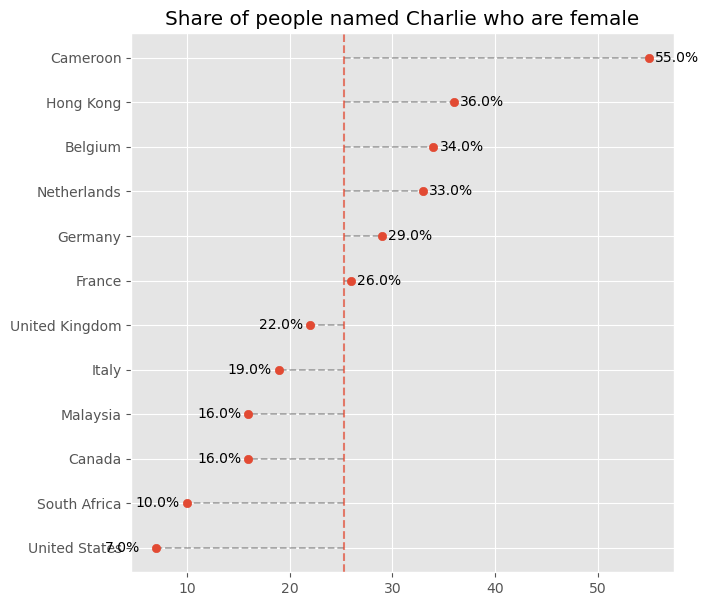

In [115]:
data = df[(df["name"] == "Charlie") & (df[["name","female"]].sum(axis=1) > 100)].sort_values("female_share").set_index("country")["female_share"]
with plt.style.context("ggplot"):
    plt.figure(figsize=(7,7))
    plt.scatter(data.values,data.index, zorder=20)
    plt.title("Share of people named Charlie who are female")
    
    mean = data.mean()
    plt.axvline(mean,alpha=0.7, linestyle="--")
    
    plt.hlines([i for i in range(len(data))], mean, data.values, alpha=0.3, linestyle="--", color="black", linewidth=1.3)
    
    for order,share in zip([i for i in range(len(data))],data.values):
        plt.text((share +0.6) if share > mean else (share -5),order,str(share) + "%", ha="left", va="center", fontsize=10)
    plt.show()

# Determining a name's likely origin

<font size="3"> Let's use the method we've used previously for surnames to assign an origin to a name

In [121]:
def gini_coefficient(x):
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

df["count"] = df[["female","male"]].sum(axis=1)

#computing the country level name frequency, removing names that have a frequency lower than 0.0000005
df["freq"] = df["count"]/df.groupby("country")["count"].transform(sum)
df = df[df["freq"] > 0.0000005]

#computing the hhi
standardized_freq = df["freq"]/df.groupby("name")["freq"].transform(sum)
df["hhi"] = (standardized_freq**2).groupby(df['name']).transform(sum)
print("hhi done")

#computing the gini index
gini = df.groupby('name')["freq"].apply(np.array).apply(gini_coefficient)
df = df.merge(gini.rename("gini"),left_on="name",right_index=True)
print("gini done")

df["mean"] = df[["gini","hhi"]].mean(axis=1)
df

hhi done
gini done


,country,name,female,male,count,freq,hhi,gini,mean
0,Afghanistan,A,0.0,16.0,16.0,0.000110,0.055199,0.55375,0.304474
6725,Albania,A,5.0,7.0,12.0,0.000029,0.055199,0.55375,0.304474
17445,Algeria,A,16.0,50.0,66.0,0.000008,0.055199,0.55375,0.304474
157299,Angola,A,3.0,7.0,10.0,0.000059,0.055199,0.55375,0.304474
165233,Argentina,A,9.0,12.0,21.0,0.000010,0.055199,0.55375,0.304474
...,...,...,...,...,...,...,...,...,...
3750889,qatar,Ãb-DóÔò,0.0,3.0,3.0,0.000002,1.000000,0.00000,0.500000
3750893,qatar,Ämģăď,0.0,3.0,3.0,0.000002,1.000000,0.00000,0.500000
3750895,qatar,Éñámùl,0.0,3.0,3.0,0.000002,1.000000,0.00000,0.500000
3750903,qatar,Ďayashankar,0.0,3.0,3.0,0.000002,1.000000,0.00000,0.500000


<font size="3"> Let's get a list of the frenchest names, that is, names that are most concentrated in France.

In [151]:
data = df.sort_values(["name","freq"],ascending=False).drop_duplicates("name")
data[ (data["count"] > 500) & (data["country"] == "France")].sort_values("mean",ascending=False)[["name","count"]][:30].reset_index(drop=True)

,name,count
0,Tiphaine,4393.0
1,Angélina,921.0
2,Erwann,1673.0
3,Rozenn,792.0
4,Nolwenn,3132.0
5,Enora,1441.0
6,Gwendal,1451.0
7,Chrystele,546.0
8,Solène,4706.0
9,Louloute,836.0


For Ireland, the most typical names are of celtic origin :

In [155]:
data[ (data["count"] > 500) & (data["country"] == "Ireland")].sort_values("mean",ascending=False)[["name","count"]][:30].reset_index(drop=True)

,name,count
0,Aoife,5047.0
1,Eoin,3920.0
2,Brid,856.0
3,Aisling,3580.0
4,Colm,2910.0
5,Padraig,1674.0
6,Cian,2805.0
7,Cillian,718.0
8,Seán,1467.0
9,Dermot,1759.0


In [174]:
files = glob("../data/first_names/fb_first_names/data/*.csv")
df_cine = pd.concat([pd.read_csv(i) for i in files])
df_cine["viewers"] = df_cine["viewers"].str.replace("Spectateurs\n","")
df_cine["actors"] = df_cine["actors"].str.strip("[]").str.replace(", ",",").str.split(",")
data = df_cine[["date","actors"]].explode("actors")
data["actors"] = data['actors'].str.strip("'")
data["date"] = data["date"].str.extract('([0-9]{4})')
data = data.dropna().reset_index(drop=True)
data['first_name'] = data['actors'].str.split().apply(lambda x : x[0]).str.strip().str.strip('"')
d = data.copy()

In [175]:
df_fr = df[df["country"] == "France"]
data_fr = data.merge(df_fr,left_on="first_name",right_on="name",how="left")

data_other = data_fr[data_fr["name"].isna()][["date","actors","first_name"]]
df_other = df.groupby("name")["female","male"].sum().reset_index()

data_other = data_other.merge(df_other,left_on="first_name",right_on="name",how="left")
data_other.loc[data_other["first_name"].isin(["Golshifteh","Lorànt","Sagamore","Féodor","JoeyStarr","Gringe","Sotigui","Louis-Do","Kheiron"]),["name","male"]] = ["ok",1000]
data_other.loc[data_other["first_name"].isin(["Miou-Miou","Linh-Dan","Lilly-Fleur"]),["name","female"]] = ["ok",1000]

data_again = data_other[data_other["name"].isna()][["date","actors","first_name"]]
data_again["first_name"] = data_again["first_name"].apply(name_cleaner).str.split("-").apply(lambda x : x[0]).str.strip()
data_again = data_again.merge(df_other,left_on="first_name",right_on="name",how="left")

data = pd.concat([data_fr[data_fr["name"].notna()],data_other[data_other["name"].notna()],data_again])
data = data[data["name"].notna()]
data["gender"] = np.where(data["male"] > data["female"],"male","female")

<ipython-input-175-37f23efb45c6>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_other = df.groupby("name")["female","male"].sum().reset_index()


In [188]:
d = data.groupby(["date","gender"])["name"].count().unstack()
d["share"] = d["female"]/(d["female"] + d["male"])*100

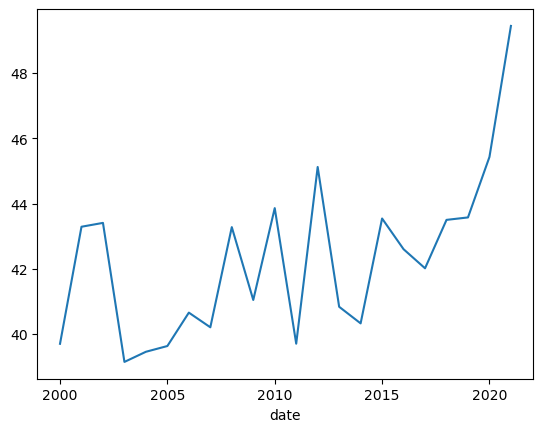

In [194]:
d["share"].plot()
plt.show()

In [209]:
data["male_share"] = (data["male"]/(data[["male","female"]].sum(axis=1)))*100

<ipython-input-209-dda409a87b82>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["male_share"] = (data["male"]/(data[["male","female"]].sum(axis=1)))*100


## macron

In [646]:
data = pd.read_csv("/home/riri/Documents/projects/agenda président/agenda_président.csv")
name1 = data["description"].str.extract('( [A-Z]+),')[0]
name2 = data["description"].str.extract('( [A-Z]+ [A-Z]+),')[0]
data["name"] = np.where(name1.isna(),name2,name1)
data["name"] = np.where(data["description"].str.contains("CARRERE").fillna(False),"CARRERE d’ENCAUSSE",data["name"] )

In [647]:
first_name1 = data["description"].str.extract(' ([A-Z]{1}[a-zéçèïüëïóá]+) [A-Z]+,')[0]
first_name2 = data["description"].str.extract(' ([A-Z]{1}[a-zéçèïüëïóá]+) [A-Z]+ [A-Z]+,')[0]
first_name1 = np.where(first_name1.isna(),first_name2,first_name1)

first_name3 = data["description"].str.extract(' ([A-Z]{1}[a-zéçèïüëïóá]+\-[A-Z]{1}[a-zéçèïü]+) [A-Z]+,')[0]
first_name4 = data["description"].str.extract(' ([A-Z]{1}[a-zéçèïüëïóá]+\-[A-Z]{1}[a-zéçèïü]+) [A-Z]+ [A-Z]+,')[0]
first_name2 = np.where(first_name3.isna(),first_name4,first_name3)


data["first_name"] = np.where(pd.Series(first_name1).isna(),first_name2,first_name1)


data.loc[data["description"].str.contains("RUGY"),'first_name'] = "François"
data.loc[data["description"].str.contains("CARRERE"),'first_name'] = "Hélène"
data.loc[data["description"].str.contains("LEYEN"),'first_name'] = "Ursula"
data.loc[data["description"].str.contains("VILLEROY de"),'first_name'] = "François"
data.loc[data["description"].str.contains("ROUX de"),'first_name'] = "Geoffroy"
#data = data["first_name"].str.strip().dropna()

In [651]:
data = df_other.merge(data,left_on="name",right_on="first_name", how="right")
data["male_share"] = (data["male"]/(data[["male","female"]].sum(axis=1)))

data.loc[(data["male_share"] < 0.8) & (data["male_share"] > 0.2),"gender"] = "epicene"
data.loc[data["male_share"] > 0.8,"gender"] = "Homme"
data.loc[data["male_share"] < 0.2,"gender"] = "Femme"

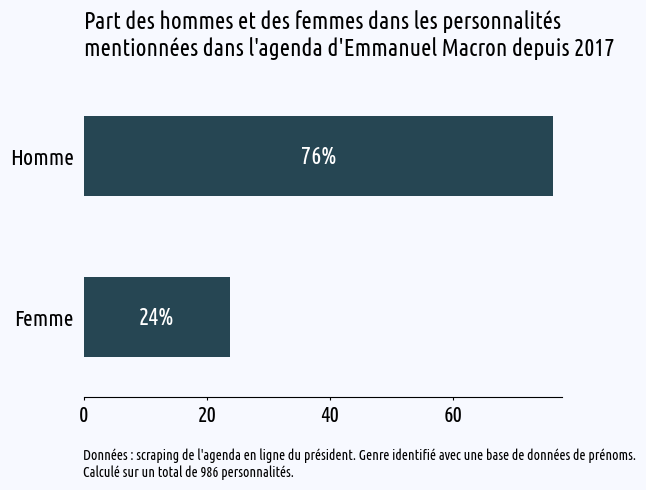

In [592]:
d = data[data["gender"] != "epicene"]["gender"].value_counts(normalize=True)*100
with plt.style.context("rirO"):
    plt.figure(figsize=(6.5,5))
    d.plot(kind='barh')
    plt.gca().invert_yaxis()
    for value, n in zip(d.values,[0,1]):
        plt.text(value/2,n,str(round(value,0))[:2] + "%", ha="center",color='white',fontsize=17,va="center")
        
    plt.title("Part des hommes et des femmes dans les personnalités\nmentionnées dans l'agenda d'Emmanuel Macron depuis 2017")
    
    plt.text(-0.07,2, "Données : scraping de l'agenda en ligne du président. Genre identifié avec une base de données de prénoms.\nCalculé sur un total de 986 personnalités.")
    
    plt.tight_layout()
    plt.savefig("macron_femmes.png",dpi=150)
    plt.show()

In [686]:
data = pd.read_csv("/home/riri/Documents/projects/agenda président/agenda_président.csv")
male = data["description"].str.extract("(M\. )")[0]
female = data["description"].str.extract("(Mme )")[0]
gender = np.where(male.isna(),female,male)
pd.Series(gender).value_counts(normalize=True)
data["gender"] = gender

M.      0.830478
Mme     0.169522
dtype: float64

In [700]:
female = data["description"].str.extractall("( Mme )")[0].reset_index(drop=True)
male = data["description"].str.extractall("( M\. )")[0].reset_index(drop=True)
gender = pd.concat([female,male])
gender.value_counts(normalize=True)

 M.      0.760542
 Mme     0.239458
Name: 0, dtype: float64

In [701]:
gender

0        Mme 
1        Mme 
2        Mme 
3        Mme 
4        Mme 
        ...  
1005      M. 
1006      M. 
1007      M. 
1008      M. 
1009      M. 
Name: 0, Length: 1328, dtype: object